### Customer Segmentation & Recency, Frequency, Monetary Modeling

We discovered some interesting observations around our cohort data set. While cohort analysis provides us with customer behavior overtime and understand retention rates, we also want to be able to segment our data by their behavior as well.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import re
from pandas.plotting import scatter_matrix
import time, warnings
import datetime as dt
import plotly.offline as py
import plotly.graph_objs as go


import warnings
warnings.filterwarnings('ignore')

In [ ]:
import gdown

file_id ='1rlcyzutEUMZaKN9IfWRyjzODBdVPtARp'
output_path = 'Olist_Master.csv'
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=True, fuzzy=True)

'Olist_Master.csv'

In [ ]:
Olist_db = pd.read_csv('Olist_Master.csv')
Olist_db

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,...,customer_unique_id,review_response_time,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,review_comment_title,review_comment_message
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,1,Credit Card,2,...,5ee8fe956c2631afc0a1dcc1920d0e3d,1,2017,9,2,8,Wed,Sep,NaN,"Perfect, product delivered ahead of schedule."
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,1,Boleto,1,...,8b3f917f4307d3e5cf34c0b43d6e6f50,3,2017,6,2,11,Wed,Jun,NaN,"Lannister, as always, delivered promptly and o..."
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,1,Credit Card,2,...,69ba88e17ea574da9c9b8c8834a583d1,1,2018,5,4,10,Fri,May,I highly recommend,very beautiful stroller
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,1,Credit Card,3,...,cbe063493a222cb17024ff0285b4ecb6,3,2017,8,1,18,Tue,Aug,NaN,NaN
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,1,Credit Card,4,...,ffab5330bd7b40979ab6726b2e02292e,3,2017,8,3,21,Thu,Aug,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116576,fdaf98feac227eb978d8f33f36e0231d,1,f739e9151702508b18f796c53005e5e9,d1aa1ec0839dcab73a6161130eb1f94a,2017-04-27 05:10:28,119.9,16.14,1,Boleto,1,...,e060eb8f37de232154b24bbb2413b68e,1,2017,4,2,10,Wed,Apr,NaN,The only problem was the packaging that opened...
116577,fe68b52db13993f58175fa589125d345,1,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,2017-08-17 02:55:27,209.0,16.21,1,Boleto,1,...,3041f5d65c4fa516eed1325d7a8657af,1,2017,8,4,10,Fri,Aug,NaN,Perfect
116578,fefacc66af859508bf1a7934eab1e97f,1,69c590f7ffc7bf8db97190b6cb6ed62e,80ceebb4ee9b31afb6c6a916a574a1e2,2018-08-02 04:05:13,6729.0,193.21,1,Boleto,1,...,57b628f46c00f9a7358e5e875d5b4dd0,0,2018,7,2,18,Wed,Jul,NaN,NaN
116579,ff701a7c869ad21de22a6994237c8a00,1,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,2018-04-18 20:10:33,27.9,14.44,1,Credit Card,1,...,ea4d52b176423e61a84052b0f4717be9,3,2018,4,3,19,Thu,Apr,NaN,NaN


In [ ]:
features = ['order_id', 'order_status', 'order_purchase_timestamp',
       'payment_value', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state']
Olist_db = Olist_db[features]
Olist_db.shape

(116581, 8)

In [ ]:
df = Olist_db.copy()
Olist_db['order_purchase_date'] = Olist_db.order_purchase_timestamp.apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S"))

In [ ]:
Olist_db = Olist_db.drop_duplicates()

In [ ]:
cond = Olist_db["order_status"] == "delivered"
Olist_db = Olist_db.loc[cond]

In [ ]:
def clustering_customers(df, date_max, date_min=False, group_range_days=False):
    df = df.copy()

    if(date_min == False):
        cond_f = df["order_purchase_date"] <= pd.to_datetime(date_max)
    else:
        cond_1 = df["order_purchase_date"] <= pd.to_datetime(date_max)
        cond_2 = df["order_purchase_date"] >= pd.to_datetime(date_min)
        cond_f = cond_1 & cond_2

    df = df.loc[cond_f]

    df["today"] = df["order_purchase_date"].max()

    df["today"] = df["today"].dt.date
    df["today"] = pd.to_datetime(df["today"], format="%Y-%m-%d")

    df["order_purchase_days_since"] = df["today"]  - df["order_purchase_date"]
    df["order_purchase_days_since"] = df["order_purchase_days_since"].astype(str)
    df["order_purchase_days_since"] = df["order_purchase_days_since"].str.replace(r'\s+days.*', '', regex=True)
    df["order_purchase_days_since"] = df["order_purchase_days_since"].astype(int)
    df["order_purchase_year"] = df["order_purchase_date"].dt.year

    agg_group = {
        "order_purchase_days_since": ["min", "max", "count"],
        "payment_value": ["sum","mean"]
    }

    df_group = df.groupby(["customer_unique_id"]).agg(agg_group).reset_index()

    df_group.columns = [' '.join(col).strip() for col in df_group.columns.values]

    columns_rename = {
        "order_purchase_days_since min": "first_order_purchase",
        "order_purchase_days_since max": "last_order_purchase",
        "order_purchase_days_since count": "order_purchase_qty",
        "payment_value mean": "payment_value_mean",
        "payment_value sum": "payment_value_sum"
    }

    df_group.rename(columns_rename, axis=1, inplace=True)

    median_payment = df_group["payment_value_mean"].median()

    if(group_range_days == False):
        major_group = 4
        range_days = str(df["order_purchase_date"].max() - df["order_purchase_date"].min())
        group_range_days = int(re.sub(r'\s+days.*', '', range_days))/major_group

    cond_payment_zero = df_group['payment_value_mean'] == 0.0

    cond_inactive_1 = df_group['last_order_purchase'] > group_range_days*3
    cond_inactive = cond_inactive_1 | cond_payment_zero

    cond_cold_1 = df_group['last_order_purchase'] > group_range_days*2
    cond_cold_2 = df_group['last_order_purchase'] <= group_range_days*3
    cond_cold = cond_cold_1 & cond_cold_2 & ~(cond_payment_zero)

    cond_hot_1 = df_group['last_order_purchase'] > group_range_days
    cond_hot_2 = df_group['last_order_purchase'] <= group_range_days*2
    cond_hot = cond_hot_1 & cond_hot_2 & ~(cond_payment_zero)

    cond_active_1 = df_group['last_order_purchase'] <= group_range_days
    cond_active = cond_active_1 & ~(cond_payment_zero)

    df_group.loc[cond_inactive, "segment"] = "inactive"
    df_group.loc[cond_cold, "segment"] = "cold"
    df_group.loc[cond_hot, "segment"] = "hot"
    df_group.loc[cond_active, "segment"] = "active"

    cond_hot_high_payment_1 = df_group["segment"] == "hot"
    cond_hot_high_payment_2 = df_group["payment_value_mean"] >= median_payment
    cond_hot_high_payment = cond_hot_high_payment_1 & cond_hot_high_payment_2

    cond_hot_low_payment_1 = df_group["segment"] == "hot"
    cond_hot_low_payment_2 = df_group["payment_value_mean"] < median_payment
    cond_hot_low_payment = cond_hot_low_payment_1 & cond_hot_low_payment_2

    cond_active_high_payment_1 = df_group["segment"] == "active"
    cond_active_high_payment_2 = df_group["payment_value_mean"] >= median_payment
    cond_active_high_payment = cond_active_high_payment_1 & cond_active_high_payment_2

    cond_active_low_payment_1 = df_group["segment"] == "active"
    cond_active_low_payment_2 = df_group["payment_value_mean"] < median_payment
    cond_active_low_payment = cond_active_low_payment_1 & cond_active_low_payment_2

    cond_cold_high_payment_1 = df_group["segment"] == "cold"
    cond_cold_high_payment_2 = df_group["payment_value_mean"] >= median_payment
    cond_cold_high_payment = cond_cold_high_payment_1 & cond_cold_high_payment_2

    cond_cold_low_payment_1 = df_group["segment"] == "cold"
    cond_cold_low_payment_2 = df_group["payment_value_mean"] < median_payment
    cond_cold_low_payment = cond_cold_low_payment_1 & cond_cold_low_payment_2

    df_group["sub_segment"] = "inactive"
    df_group.loc[cond_hot_high_payment, "sub_segment"] = "hot_high_payment_value"
    df_group.loc[cond_hot_low_payment, "sub_segment"] = "hot_low_payment_value"
    df_group.loc[cond_active_high_payment, "sub_segment"] = "active_high_payment_value"
    df_group.loc[cond_active_low_payment, "sub_segment"] = "active_low_payment_value"
    df_group.loc[cond_cold_high_payment, "sub_segment"] = "cold_high_payment_value"
    df_group.loc[cond_cold_low_payment, "sub_segment"] = "cold_low_payment_value"

    cond_new_customer = df_group["first_order_purchase"] <= group_range_days*2
    df_group["new_customer"] = 0
    df_group.loc[cond_new_customer, "new_customer"] = 1

    return group_range_days, df_group

In [ ]:
period_2018, df_clustering_2018 = clustering_customers(Olist_db, "2018-12-31")
df_clustering_2018.head()

,customer_unique_id,first_order_purchase,last_order_purchase,order_purchase_qty,payment_value_sum,payment_value_mean,segment,sub_segment,new_customer
0,0000b849f77a49e4a4ce2b2a4ca5be3f,168,279,2,136.26,68.130000,hot,hot_low_payment_value,1
1,0000f46a3911fa3c0805444483337064,124,392,3,583.87,194.623333,cold,cold_high_payment_value,1
2,0004bd2a26a76fe21f786e4fbd80607f,6,443,3,336.11,112.036667,cold,cold_low_payment_value,1
3,00050ab1314c0e55a6ca13cf7181fecf,218,218,1,80.18,80.180000,hot,hot_low_payment_value,1
4,0005ef4cd20d2893f0d9fbd94d3c0d97,480,480,1,187.91,187.910000,cold,cold_high_payment_value,0


In [ ]:
df_revenue_subsegment_2018 = df_clustering_2018.groupby(["sub_segment"]).agg({"payment_value_sum": "sum"}).reset_index()


configure_plotly_browser_state()
trace0 = go.Bar(
    x=df_revenue_subsegment_2018["sub_segment"].values,
    y=df_revenue_subsegment_2018["payment_value_sum"].values,
    marker=dict(
        color=['rgba(36,123,160,1)',
               'rgba(75,147,177,1)',
               'rgba(112,193,179,1)',
               'rgba(138,204,192,1)',
               'rgba(243,255,189,1)',
               'rgba(247,255,213,1)',
               'rgba(255,22,84,1)']),
)

data = [trace0]

layout = go.Layout(
    title='Revenue 2018',
    xaxis=dict(
        title='Sub Segment'
    ),
    yaxis=dict(
        title='Total Payment Value ($)'
    )
)

fig = go.Figure(data=data, layout=layout)

In [ ]:
py.iplot(fig)

In [ ]:
df_clustering_2018_qty = df_clustering_2018.loc[df_clustering_2018["order_purchase_qty"] > 1]

df_qty_subsegment_2018 = df_clustering_2018_qty.groupby(["sub_segment"]).agg({"order_purchase_qty": "count"}).reset_index()

In [ ]:
configure_plotly_browser_state()
trace0 = go.Bar(
    x=df_qty_subsegment_2018["sub_segment"].values,
    y=df_qty_subsegment_2018["order_purchase_qty"].values,
    marker=dict(
        color=['rgba(36,123,160,1)',
               'rgba(75,147,177,1)',
               'rgba(112,193,179,1)',
               'rgba(138,204,192,1)',
               'rgba(243,255,189,1)',
               'rgba(247,255,213,1)',
               'rgba(255,22,84,1)']),
)

data = [trace0]

layout = go.Layout(
    title='Repurchase Amount 2018',
    xaxis=dict(
        title='Sub Segment'
    ),
    yaxis=dict(
        title='Order Purchase Quantity'
    )
)

fig = go.Figure(data=data, layout=layout)

In [ ]:
py.iplot(fig)

In [ ]:
df_days_repurchase_subsegment_2018 = df_clustering_2018_qty.groupby(["sub_segment"]).agg({"first_order_purchase": "mean", "last_order_purchase": "mean"}).reset_index()

df_days_repurchase_subsegment_2018["diff_order_purchase"] = df_days_repurchase_subsegment_2018["last_order_purchase"].values - df_days_repurchase_subsegment_2018["first_order_purchase"].values

df_days_repurchase_subsegment_2018["diff_order_purchase"] = df_days_repurchase_subsegment_2018["diff_order_purchase"].round(0)

In [ ]:
configure_plotly_browser_state()
trace0 = go.Bar(
    x=df_days_repurchase_subsegment_2018["sub_segment"].values,
    y=df_days_repurchase_subsegment_2018["diff_order_purchase"].values,
    marker=dict(
        color=['rgba(36,123,160,1)',
               'rgba(75,147,177,1)',
               'rgba(112,193,179,1)',
               'rgba(138,204,192,1)',
               'rgba(243,255,189,1)',
               'rgba(247,255,213,1)',
               'rgba(255,22,84,1)']),
)

data = [trace0]

layout = go.Layout(
    title='Avg Days Between First and Last Purchase in 2018',
    xaxis=dict(
        title='Sub Segment'
    ),
    yaxis=dict(
        title='Average Days'
    )
)

fig = go.Figure(data=data, layout=layout)

In [ ]:
py.iplot(fig)

In [ ]:
period_2017, df_clustering_2017 = clustering_customers(Olist_db, "2017-12-31")

df_clustering_2017.head()

,customer_unique_id,first_order_purchase,last_order_purchase,order_purchase_qty,payment_value_sum,payment_value_mean,segment,sub_segment,new_customer
0,0000b849f77a49e4a4ce2b2a4ca5be3f,37,37,1,98.88,98.880,active,active_low_payment_value,1
1,0000f46a3911fa3c0805444483337064,107,150,2,255.25,127.625,hot,hot_high_payment_value,1
2,0004bd2a26a76fe21f786e4fbd80607f,201,201,1,45.77,45.770,hot,hot_low_payment_value,1
3,0005ef4cd20d2893f0d9fbd94d3c0d97,238,238,1,187.91,187.910,cold,cold_high_payment_value,0
4,000c8bdb58a29e7115cfc257230fb21b,325,325,1,441.33,441.330,cold,cold_high_payment_value,0


## RFM Modeling

## Phân đoạn hành vi theo 3 đặc điểm quan trọng:
- Recency — số ngày kể từ lần mua cuối cùng
- Frequency — số lượng giao dịch được thực hiện trong một khoảng thời gian nhất định
- Monetary — số tiền chi tiêu trong một khoảng thời gian nhất định

In [ ]:
!pip install -q squarify

from datetime import timedelta, datetime
import squarify

In [ ]:
Olist_db.columns

Index(['order_id', 'order_status', 'order_purchase_timestamp', 'payment_value',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_purchase_date'],
      dtype='object')

In [ ]:
Olist_db['InvoiceDate'] = Olist_db.order_purchase_date.apply(lambda x : datetime.strftime(x, '%Y-%m-%d'))

In [ ]:
Olist_db['InvoiceDate'] = pd.to_datetime(Olist_db['InvoiceDate'])

In [ ]:
print('{:,} rows; {:,} columns'
      .format(Olist_db.shape[0], Olist_db.shape[1]))
print('{:,} transactions don\'t have a customer id'
      .format(Olist_db[Olist_db.customer_unique_id.isnull()].shape[0]))
print('Transactions timeframe from {} to {}'.format(Olist_db['InvoiceDate'].min(),
                                    Olist_db['InvoiceDate'].max()))

98,770 rows; 10 columns
0 transactions don't have a customer id
Transactions timeframe from 2016-10-03 00:00:00 to 2018-08-29 00:00:00


In [ ]:
# Create snapshot date
snapshot_date = Olist_db['InvoiceDate'].max() + timedelta(days=1)
snapshot_date

Timestamp('2018-08-30 00:00:00')

In [ ]:
# Grouping by CustomerID
data_process = Olist_db.groupby(['customer_unique_id']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'order_id': 'count',
        'payment_value': 'sum'})

In [ ]:
data_process.rename(columns={'InvoiceDate': 'Recency',
                         'order_id': 'Frequency',
                         'payment_value': 'Monetary'}, inplace=True)
data_process

,Recency,Frequency,Monetary
customer_unique_id,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,170,2,136.26
0000f46a3911fa3c0805444483337064,126,3,583.87
0004bd2a26a76fe21f786e4fbd80607f,8,3,336.11
00050ab1314c0e55a6ca13cf7181fecf,220,1,80.18
0005ef4cd20d2893f0d9fbd94d3c0d97,482,1,187.91
...,...,...,...
fffa431dd3fcdefea4b1777d114144f2,163,3,1643.43
fffb09418989a0dbff854a28163e47c6,294,1,329.38
fffbf87b7a1a6fa8b03f081c5f51a201,52,2,199.50


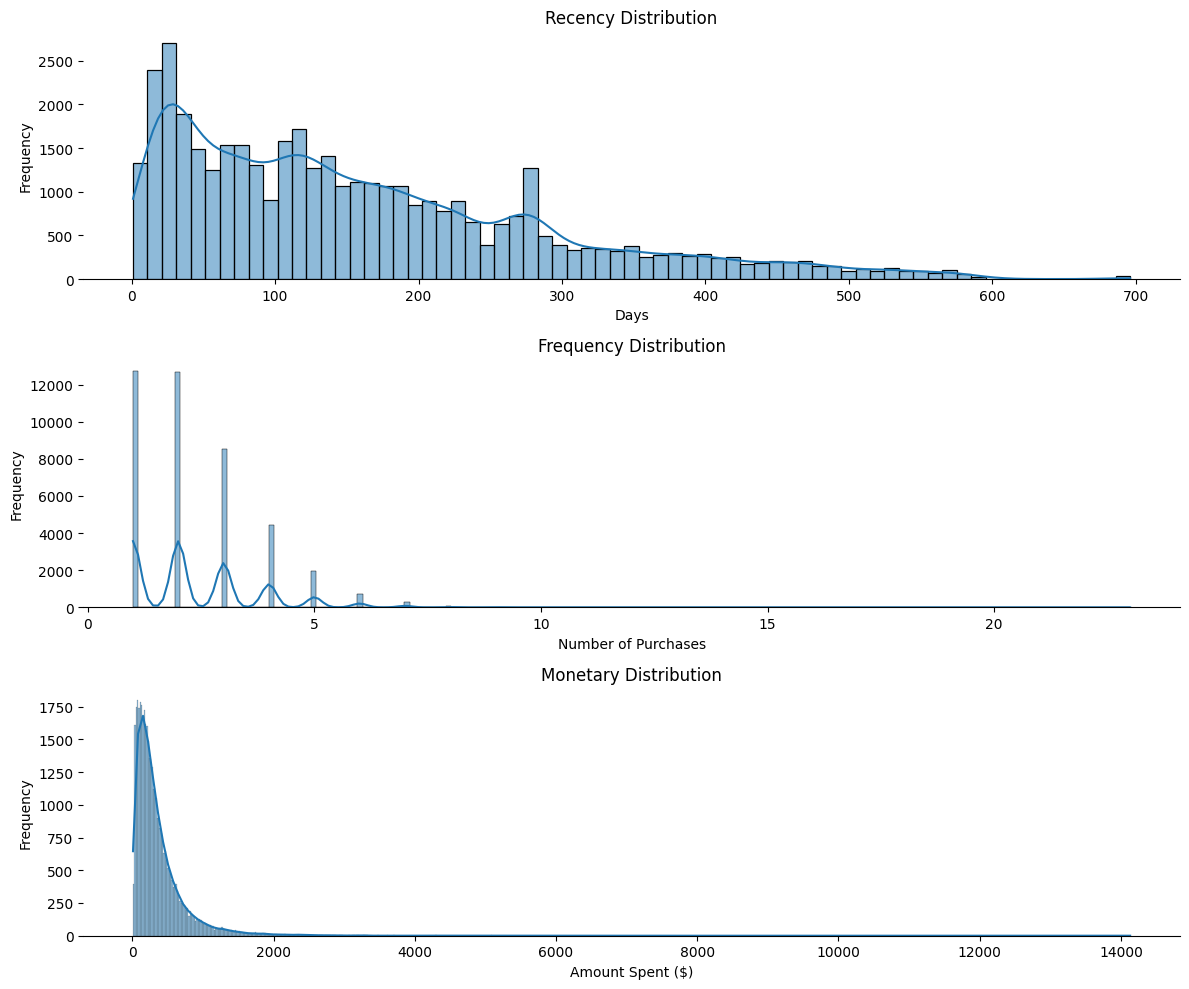

In [ ]:
def plot_rfm_distributions(data):
    """
    Plots the distribution of Recency, Frequency, and Monetary values.

    Args:
        data (pd.DataFrame): DataFrame containing RFM values.
    """

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=False)
    sns.despine(left=True)

    # Plot Recency distribution
    sns.histplot(data['Recency'], ax=axes[0], kde=True)
    axes[0].set_title('Recency Distribution')
    axes[0].set_xlabel('Days')
    axes[0].set_ylabel('Frequency')

    # Plot Frequency distribution
    sns.histplot(data['Frequency'], ax=axes[1], kde=True)
    axes[1].set_title('Frequency Distribution')
    axes[1].set_xlabel('Number of Purchases')
    axes[1].set_ylabel('Frequency')

    # Plot Monetary distribution
    sns.histplot(data['Monetary'], ax=axes[2], kde=True)
    axes[2].set_title('Monetary Distribution')
    axes[2].set_xlabel('Amount Spent ($)')
    axes[2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example usage
plot_rfm_distributions(data_process)

In [ ]:
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 4)
# Assign these labels to 4 equal percentile groups
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels, duplicates='drop')
# Create new columns R and F
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()
data_process["R"].value_counts()
data_process["F"].value_counts()

F
1    25388
2     8508
3     7535
Name: count, dtype: int64

In [ ]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups
m_groups = pd.qcut(data_process['Monetary'], q=4, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)

In [ ]:
data_process

,Recency,Frequency,Monetary,R,F,M
customer_unique_id,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,170,2,136.26,2,1,2
0000f46a3911fa3c0805444483337064,126,3,583.87,3,2,4
0004bd2a26a76fe21f786e4fbd80607f,8,3,336.11,4,2,3
00050ab1314c0e55a6ca13cf7181fecf,220,1,80.18,2,1,1
0005ef4cd20d2893f0d9fbd94d3c0d97,482,1,187.91,1,1,2
...,...,...,...,...,...,...
fffa431dd3fcdefea4b1777d114144f2,163,3,1643.43,2,2,4
fffb09418989a0dbff854a28163e47c6,294,1,329.38,1,1,3
fffbf87b7a1a6fa8b03f081c5f51a201,52,2,199.50,4,1,2


In [ ]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x):
    return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))

data_process['RFM_Segment'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
customer_unique_id,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,170,2,136.26,2,1,2,212
0000f46a3911fa3c0805444483337064,126,3,583.87,3,2,4,324
0004bd2a26a76fe21f786e4fbd80607f,8,3,336.11,4,2,3,423
00050ab1314c0e55a6ca13cf7181fecf,220,1,80.18,2,1,1,211
0005ef4cd20d2893f0d9fbd94d3c0d97,482,1,187.91,1,1,2,112


In [ ]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment')['RFM_Segment'].nunique()
print(rfm_count_unique.sum())

48


In [ ]:
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())
rfm

customer_unique_id
0000b849f77a49e4a4ce2b2a4ca5be3f    5
0000f46a3911fa3c0805444483337064    9
0004bd2a26a76fe21f786e4fbd80607f    9
00050ab1314c0e55a6ca13cf7181fecf    4
0005ef4cd20d2893f0d9fbd94d3c0d97    4
Name: RFM_Score, dtype: int64


,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,170,2,136.26,2,1,2,212,5
0000f46a3911fa3c0805444483337064,126,3,583.87,3,2,4,324,9
0004bd2a26a76fe21f786e4fbd80607f,8,3,336.11,4,2,3,423,9
00050ab1314c0e55a6ca13cf7181fecf,220,1,80.18,2,1,1,211,4
0005ef4cd20d2893f0d9fbd94d3c0d97,482,1,187.91,1,1,2,112,4
...,...,...,...,...,...,...,...,...
fffa431dd3fcdefea4b1777d114144f2,163,3,1643.43,2,2,4,224,8
fffb09418989a0dbff854a28163e47c6,294,1,329.38,1,1,3,113,5
fffbf87b7a1a6fa8b03f081c5f51a201,52,2,199.50,4,1,2,412,7


### Segmentation using RFM Analysis

In [ ]:
def rfm_level(df):
    """
    Assigns RFM level based on RFM segment and score.

    Args:
        df (pd.Series): Series containing 'RFM_Segment' and 'RFM_Score' values.

    Returns:
        str: RFM level.
    """

    rfm_segment = df['RFM_Segment']
    rfm_score = df['RFM_Score']
    f = df['F']
    m = df['M']
    r = df['R']

    if rfm_segment >= 434 or rfm_score >= 9:
        return 'VVIP - Can\'t Loose Them'
    elif rfm_score >= 8 and m == 4:
        return 'Champions Big Spenders'
    elif rfm_score >= 6 and f >= 2:
        return 'Loyal Customers'
    elif rfm_segment >= 221 or rfm_score >= 6:
        return 'Potential Loyalists'
    elif (rfm_segment >= 121 and r == 1) or rfm_score == 5:
        return 'Needs Attention'
    elif rfm_score >= 4 and r == 1:
        return 'Hibernating - Almost Lost'
    else:
        return 'Lost Customers'

In [ ]:
def rfm_action(df):
    """
    Recommends actions based on RFM segment and score.

    Args:
        df (pd.Series): Series containing 'RFM_Segment', 'RFM_Score', 'F', 'M', and 'R' values.

    Returns:
        str: Recommended action.
    """

    rfm_segment = df['RFM_Segment']
    rfm_score = df['RFM_Score']
    f = df['F']
    m = df['M']
    r = df['R']

    if rfm_segment >= 434 or rfm_score >= 9:
        return 'No Price Incentives; Offer Limited edition and Loyalty programs'
    elif rfm_score >= 8 and m == 4:
        return 'Upsell most expensive items'
    elif rfm_score >= 6 and f >= 2:
        return 'Loyalty programs; Cross Sell'
    elif rfm_segment >= 221 or rfm_score >= 6:
        return 'Cross Sell Recommendations and Discount coupons'
    elif (rfm_segment >= 121 and r == 1) or rfm_score == 5:
        return 'Price incentives and Limited time offer'
    elif rfm_score >= 4 and r == 1:
        return 'Aggressive price incentives'
    else:
        return 'Don\'t spend too much trying to re-acquire'

In [ ]:
# Create a new variable RFM_Level
rfm['RFM_Segment'] = rfm.RFM_Segment.apply(lambda x: int(x))
rfm['Customer Segment'] = rfm.apply(rfm_level, axis=1)
# Create a new variable RFM_Level
rfm['Marketing Action'] = rfm.apply(rfm_action, axis=1)
rfm.head(10)

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Customer Segment,Marketing Action
customer_unique_id,,,,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,170,2,136.26,2,1,2,212,5,Needs Attention,Price incentives and Limited time offer
0000f46a3911fa3c0805444483337064,126,3,583.87,3,2,4,324,9,VVIP - Can't Loose Them,No Price Incentives; Offer Limited edition and...
0004bd2a26a76fe21f786e4fbd80607f,8,3,336.11,4,2,3,423,9,VVIP - Can't Loose Them,No Price Incentives; Offer Limited edition and...
00050ab1314c0e55a6ca13cf7181fecf,220,1,80.18,2,1,1,211,4,Lost Customers,Don't spend too much trying to re-acquire
0005ef4cd20d2893f0d9fbd94d3c0d97,482,1,187.91,1,1,2,112,4,Hibernating - Almost Lost,Aggressive price incentives
000949456b182f53c18b68d6babc79c1,106,1,116.90,3,1,1,311,5,Potential Loyalists,Cross Sell Recommendations and Discount coupons
000a5ad9c4601d2bbdd9ed765d5213b3,168,1,462.72,2,1,4,214,7,Potential Loyalists,Cross Sell Recommendations and Discount coupons
000c8bdb58a29e7115cfc257230fb21b,227,2,852.54,2,1,4,214,7,Potential Loyalists,Cross Sell Recommendations and Discount coupons
000de6019bb59f34c099a907c151d855,24,1,96.66,4,1,1,411,6,Potential Loyalists,Cross Sell Recommendations and Discount coupons


In [ ]:
rfm["Customer Segment"].value_counts()

Customer Segment
Potential Loyalists          11492
VVIP - Can't Loose Them       9909
Lost Customers                6856
Loyal Customers               5335
Needs Attention               3735
Hibernating - Almost Lost     2541
Champions Big Spenders        1563
Name: count, dtype: int64

In [ ]:
value_counts = rfm["Customer Segment"].value_counts()
percentages = value_counts / len(rfm) * 100

print(percentages)

Customer Segment
Potential Loyalists          27.737684
VVIP - Can't Loose Them      23.916874
Lost Customers               16.547995
Loyal Customers              12.876831
Needs Attention               9.014989
Hibernating - Almost Lost     6.133089
Champions Big Spenders        3.772537
Name: count, dtype: float64


### Group Customer by their Customer Segment

In [ ]:
# Calculate average values for each Customer Segment, and return a size of each segment
rfm_level_agg = rfm.groupby('Customer Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'],
    'Marketing Action': 'unique'
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)
rfm.shape
rfm_level_agg.shape

                          Recency Frequency Monetary         \
                             mean      mean     mean  count   
Customer Segment                                              
Champions Big Spenders      160.5       2.8    816.2   1563   
Hibernating - Almost Lost   349.1       1.4    188.0   2541   
Lost Customers              298.5       1.2     78.2   6856   
Loyal Customers             148.6       3.2    319.8   5335   
Needs Attention             245.6       1.8    241.5   3735   
Potential Loyalists         102.8       1.6    279.4  11492   
VVIP - Can't Loose Them      61.6       4.0    716.5   9909   

                                                            Marketing Action  
                                                                      unique  
Customer Segment                                                              
Champions Big Spenders                         [Upsell most expensive items]  
Hibernating - Almost Lost                      [Aggre

(7, 5)

In [ ]:
rfm_level_ag = pd.DataFrame(rfm_level_agg)
rfm_level_ag = rfm_level_ag.reset_index()
rfm_level_ag

Customer Segment Recency Frequency Monetary         \
                                mean      mean     mean  count   
0     Champions Big Spenders   160.5       2.8    816.2   1563   
1  Hibernating - Almost Lost   349.1       1.4    188.0   2541   
2             Lost Customers   298.5       1.2     78.2   6856   
3            Loyal Customers   148.6       3.2    319.8   5335   
4            Needs Attention   245.6       1.8    241.5   3735   
5        Potential Loyalists   102.8       1.6    279.4  11492   
6    VVIP - Can't Loose Them    61.6       4.0    716.5   9909   

                                    Marketing Action  
                                              unique  
0                      [Upsell most expensive items]  
1                      [Aggressive price incentives]  
2        [Don't spend too much trying to re-acquire]  
3                     [Loyalty programs; Cross Sell]  
4          [Price incentives and Limited time offer]  
5  [Cross Sell Recommendations and Discount coupons]  
6  [No Price Incentives; Offer Limited edition an...

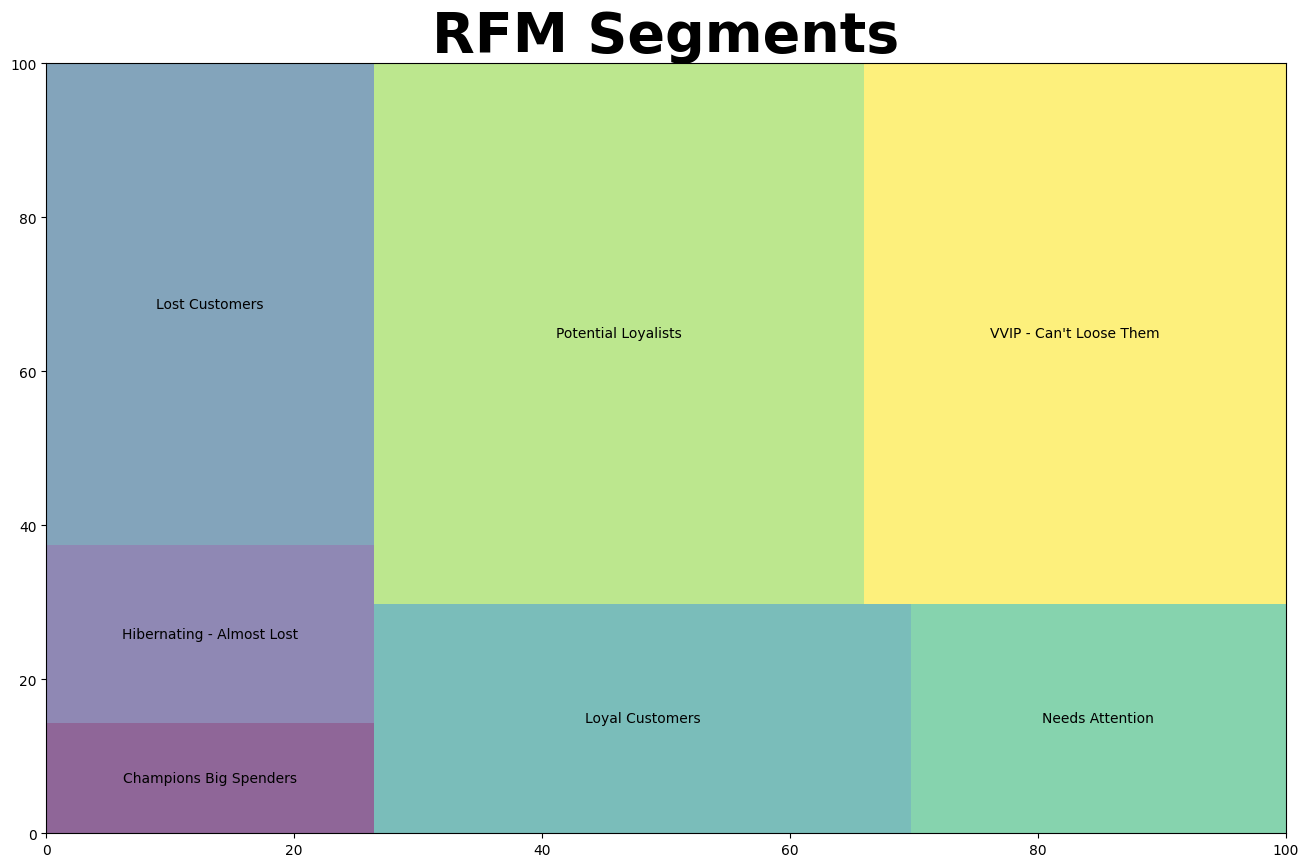

In [ ]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count', 'MarketingAction']

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)

colors = plt.cm.viridis(np.linspace(0, 1, len(rfm_level_agg['Count'])))

squarify.plot(sizes=rfm_level_agg['Count'],
              label=['Champions Big Spenders',
                     'Hibernating - Almost Lost',
                     'Lost Customers',
                     'Loyal Customers',
                     'Needs Attention',
                     'Potential Loyalists',
                     'VVIP - Can\'t Loose Them'],
              alpha=.6, color=colors)

plt.title("RFM Segments",fontsize=40,fontweight="bold")
plt.axis('on')
plt.show()

* Mỗi hình chữ nhật đại diện cho một phân khúc khách hàng có hồ sơ RFM cụ thể.
* Kích thước của mỗi hình chữ nhật tỷ lệ thuận với số lượng khách hàng trong phân khúc đó. Hình chữ nhật lớn hơn biểu thị các phân khúc lớn hơn với nhiều khách hàng hơn.


In [ ]:
rfm_level_ag

Customer Segment Recency Frequency Monetary         \
                                mean      mean     mean  count   
0     Champions Big Spenders   160.5       2.8    816.2   1563   
1  Hibernating - Almost Lost   349.1       1.4    188.0   2541   
2             Lost Customers   298.5       1.2     78.2   6856   
3            Loyal Customers   148.6       3.2    319.8   5335   
4            Needs Attention   245.6       1.8    241.5   3735   
5        Potential Loyalists   102.8       1.6    279.4  11492   
6    VVIP - Can't Loose Them    61.6       4.0    716.5   9909   

                                    Marketing Action  
                                              unique  
0                      [Upsell most expensive items]  
1                      [Aggressive price incentives]  
2        [Don't spend too much trying to re-acquire]  
3                     [Loyalty programs; Cross Sell]  
4          [Price incentives and Limited time offer]  
5  [Cross Sell Recommendations and Discount coupons]  
6  [No Price Incentives; Offer Limited edition an...

### Interactive Chart for Visualising Customer Segments

In [ ]:
def plot_rfm_treemap(rfm_level_ag):
    """
    Creates a Treemap visualization of RFM customer segments.

    Args:
        rfm_level_ag (pd.DataFrame): DataFrame containing aggregated RFM data.
    """

    fig = go.Figure(
        go.Treemap(
            labels=rfm_level_ag['Customer Segment'],
            parents=['Customer Segmentation'] * len(rfm_level_ag),  # Efficiently create parents list
            values=rfm_level_ag[('Monetary', 'count')],
        )
    )

    fig.show()

# Example usage
plot_rfm_treemap(rfm_level_ag)

### K-Means Clustering

Chúng tôi đã xây dựng cẩn thận các cụm dựa trên điểm RFM và phân khúc khách hàng. Bây giờ, hãy áp dụng phương pháp Machine Learning để xác định xem có bất kỳ phân đoạn ẩn nào mà chúng tôi có thể tìm thấy từ các cụm hay không.

In [ ]:
data_rfm = rfm[['Recency', 'Frequency', 'Monetary']]
data_rfm.min()

Recency      1.00
Frequency    1.00
Monetary     9.59
dtype: float64

Đoạn mã này áp dụng chuyển đổi logarithm vào biến data_rfm, sau đó chuẩn hóa bằng cách sử dụng lớp StandardScaler. Kết quả là một DataFrame chuẩn hóa có tên data_normalized, trong đó giá trị đã được chia tỷ lệ có trung bình bằng 0 và phương sai bằng 1, làm cho chúng phù hợp với một số phân tích thống kê và thuật toán học máy yêu cầu dữ liệu tuân theo phân phối chuẩn.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

data_log = np.log(data_rfm)
scaler = StandardScaler()
scaler.fit(data_log)
data_normalized = scaler.transform(data_log)
data_normalized = pd.DataFrame(data=data_normalized, index=data_rfm.index, columns=data_rfm.columns)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_
data_rfm_k5 = data_rfm.assign(Cluster=cluster_labels)
grouped = data_rfm_k5.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0          33.5       1.6    182.1   4668
1         276.3       1.0    109.0  10121
2         198.4       2.1    282.6  11910
3         139.8       3.7    708.9   8656
4          26.4       3.8    617.7   6076

Để tìm giá trị 'k' nào phù hợp hơn với dữ liệu, chúng ta sẽ sử dụng phương pháp khuỷu tay.

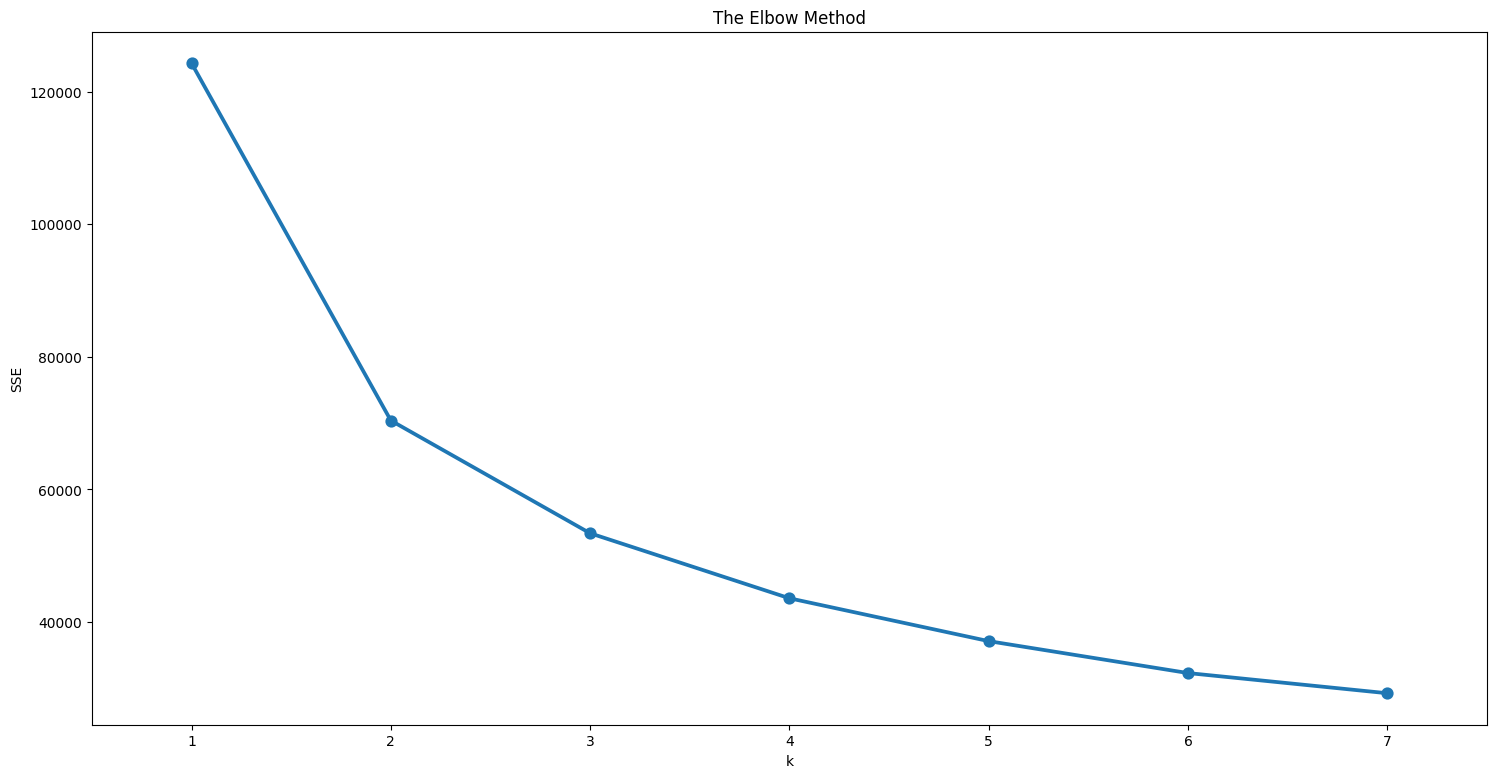

In [ ]:
sse = {}
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_
plt.figure(figsize=(18,9))

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_
data_rfm_k4 = data_rfm.assign(Cluster=cluster_labels)
grouped = data_rfm_k4.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0          77.4       4.2    788.9   9284
1         262.3       1.1    113.9  11325
2          27.6       2.2    255.5   6336
3         194.8       2.4    343.5  14486

In [ ]:
data_rfm_k4["Cluster"].value_counts()

Cluster
3    14486
1    11325
0     9284
2     6336
Name: count, dtype: int64

In [ ]:
value_counts = data_rfm_k4["Cluster"].value_counts()
percentages = value_counts / len(data_rfm_k4) * 100

print(percentages)

Cluster
3    34.964157
1    27.334605
0    22.408342
2    15.292897
Name: count, dtype: float64


In [ ]:
cluster_avg = data_rfm_k4.groupby(['Cluster']).mean()
cluster_avg

,Recency,Frequency,Monetary
Cluster,,,
0,77.394227,4.170939,788.891561
1,262.333687,1.063488,113.869249
2,27.573390,2.154672,255.456971
3,194.838189,2.371324,343.504328


In [ ]:
data_rfm_k4.shape

(41431, 4)

In [ ]:
data_melt = pd.melt(
                    data_rfm_k4.reset_index(),
                    id_vars=['customer_unique_id', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'Monetary'],
                    var_name='Metric', value_name='Value'
                    )
print(data_melt.shape)
data_melt.head(10)

(124293, 4)


,customer_unique_id,Cluster,Metric,Value
0,0000b849f77a49e4a4ce2b2a4ca5be3f,3,Recency,170.0
1,0000f46a3911fa3c0805444483337064,0,Recency,126.0
2,0004bd2a26a76fe21f786e4fbd80607f,2,Recency,8.0
3,00050ab1314c0e55a6ca13cf7181fecf,1,Recency,220.0
4,0005ef4cd20d2893f0d9fbd94d3c0d97,1,Recency,482.0
5,000949456b182f53c18b68d6babc79c1,1,Recency,106.0
6,000a5ad9c4601d2bbdd9ed765d5213b3,3,Recency,168.0
7,000c8bdb58a29e7115cfc257230fb21b,3,Recency,227.0
8,000de6019bb59f34c099a907c151d855,2,Recency,24.0
9,000ec5bff359e1c0ad76a81a45cb598f,2,Recency,53.0


In [ ]:
data_melt["Metric"].value_counts()

Metric
Recency      41431
Frequency    41431
Monetary     41431
Name: count, dtype: int64

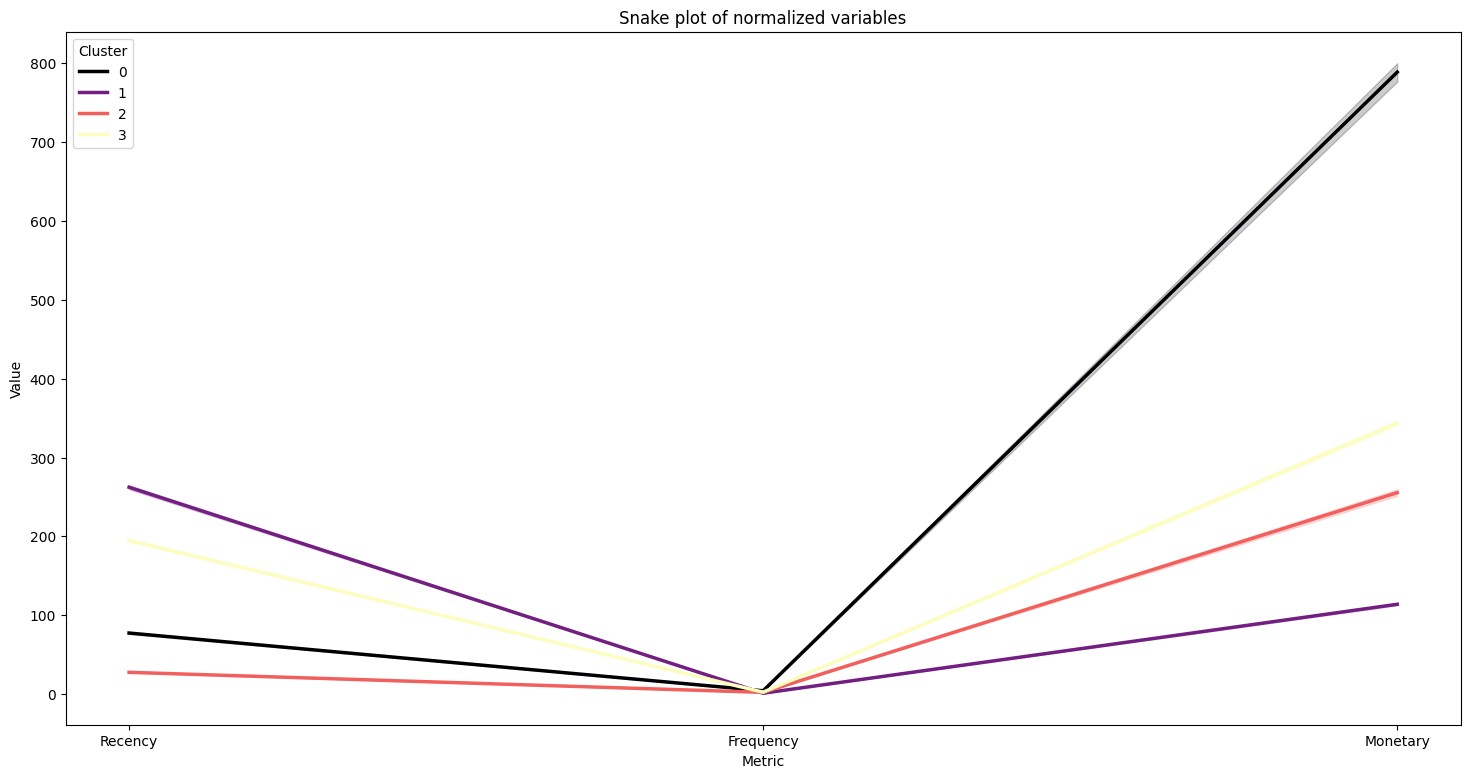

In [ ]:
# Giả sử data_melt là DataFrame đã được chuẩn bị
plt.figure(figsize = (18,9))
plt.title('Snake plot of normalized variables')
plt.xlabel('Metric')
plt.ylabel('Value')

# Sử dụng bảng màu 'magma' và tăng độ dày đường
sns.lineplot(data=data_melt, x='Metric', y='Value', hue='Cluster', palette='magma', linewidth=2.5)

plt.show()

In [ ]:
# data_rfm_k4['customer_unique_id'] = data_rfm.index

# cluster_agg = data_rfm_k4.groupby('Cluster').agg(
#     RecencyMean=('Recency', 'mean'),
#     FrequencyMean=('Frequency', 'mean'),
#     MonetaryMean=('Monetary', 'mean'),
#     Count=('customer_unique_id', 'count')
# ).round(1)

# # Chuẩn bị dữ liệu cho squarify
# sizes = cluster_agg['Count'].values
# labels = [f'Cluster {i}' for i in range(len(cluster_agg))]

# # Vẽ biểu đồ Treemap
# plt.figure(figsize=(16, 10))
# colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_agg['Count'])))
# squarify.plot(sizes=sizes, label=labels, alpha=0.6, color=colors)

# plt.title("K-Means Clusters", fontsize=40, fontweight="bold")
# plt.axis('on')
# plt.show()

### Calculate relative importance of each attribute
Now we will calculate the relative importance of the RFM values within each cluster.

In [ ]:
cluster_avg = data_rfm_k4.groupby(['Cluster']).mean()
population_avg = data_rfm.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,-0.52,0.75,1.15
1,0.63,-0.55,-0.69
2,-0.83,-0.10,-0.30
3,0.21,-0.01,-0.06


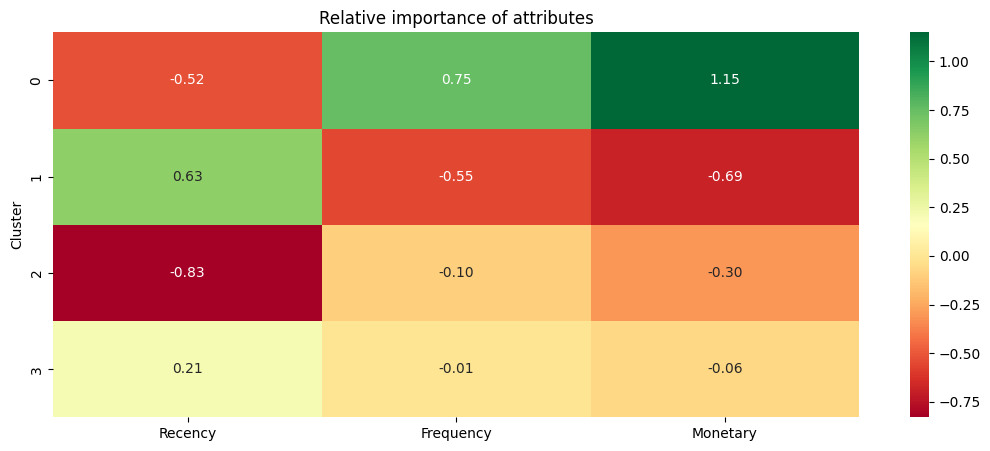

In [ ]:
plt.figure(figsize=(13, 5))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()